# Flower Recognition
Based on the code from https://github.com/lmeazzini/Flower-Recognition

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random
import tensorflow as tf
import cv2 as cv
import os 
import glob


2022-07-11 07:46:12.556003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 07:46:12.556031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Reading the data
Dataset available at 
https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [2]:
daisy_dir = glob.glob(os.path.join('../data/flowers/daisy/', '*'))
dandelion_dir = glob.glob(os.path.join('../data/flowers/dandelion/', '*'))
rose_dir = glob.glob(os.path.join('../data/flowers/rose/', '*'))
sunflower_dir = glob.glob(os.path.join('../data/flowers/sunflower/', '*'))
tulip_dir = glob.glob(os.path.join('../data/flowers/tulip/', '*'))

In [3]:
X_path = daisy_dir + dandelion_dir + rose_dir + sunflower_dir + tulip_dir

X = []

for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) 

X = np.array(X)
X = X / 255

## Label the data

In [4]:
l_daisy = np.zeros(len(daisy_dir))
l_daisy_string = ['daisy' for i in range(len(daisy_dir))]
l_dandelion = np.ones(len(dandelion_dir))
l_dandelion_string = ['dandelion' for i in range(len(dandelion_dir))]
l_rose = 2*np.ones(len(rose_dir))
l_rose_string = ['rose' for i in range(len(rose_dir))]
l_sunflower = 3*np.ones(len(sunflower_dir))
l_sunflower_string = ['sunflower' for i in range(len(sunflower_dir))]
l_tulip = 4*np.ones(len(tulip_dir))
l_tulip_string = ['tulip' for i in range(len(tulip_dir))]


y_string = np.concatenate((l_daisy_string, l_dandelion_string, l_rose_string, l_sunflower_string, l_tulip_string))
y = np.concatenate((l_daisy, l_dandelion, l_rose, l_sunflower, l_tulip))
y = to_categorical(y, 5)


## Plotting a sample of the images

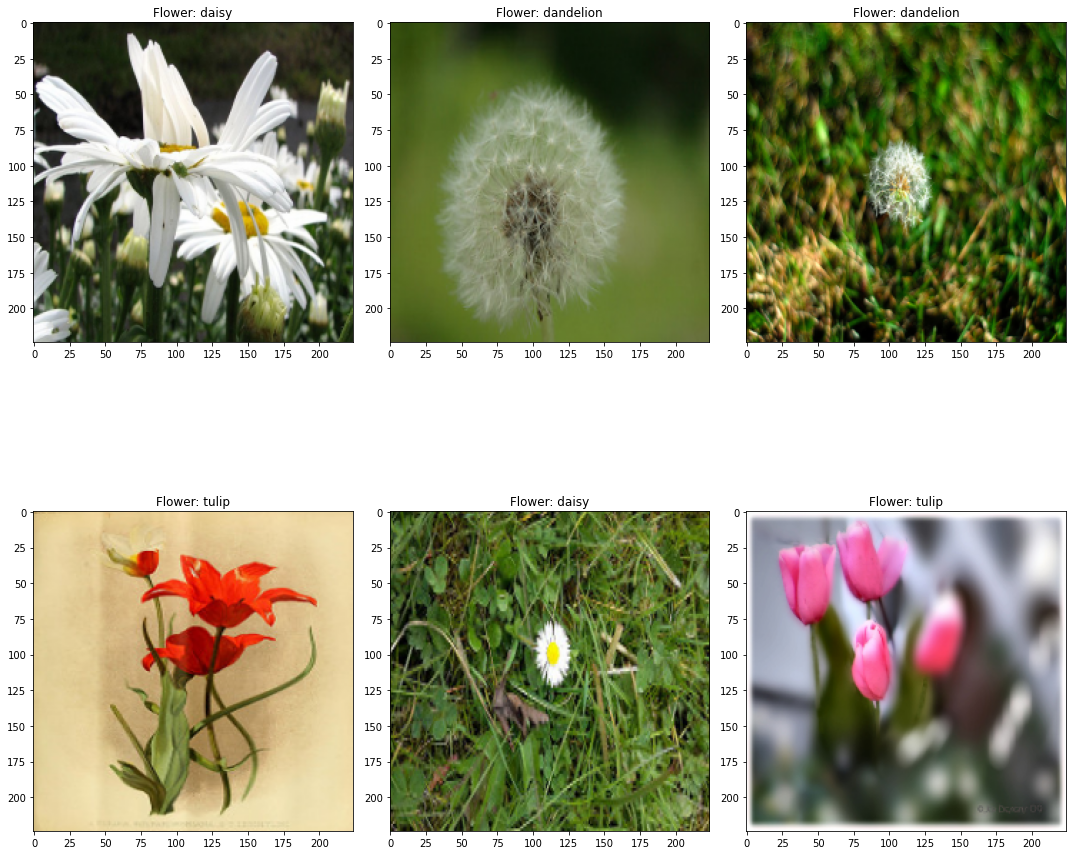

In [5]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (3):
        r = random.randint(0,len(y_string))
        ax[i,j].imshow(X[r][:,:,::-1])
        ax[i,j].set_title('Flower: ' + y_string[r])
        
plt.tight_layout()

## Train/validation set splitting

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X = []

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True) 

datagen.fit(X_train)

## Define a CNN architecture

In [8]:
inp = Input((224,224,3))

conv1 = Conv2D(64, (5,5), padding='valid', activation='relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)

conv2 = Conv2D(96, (4,4), padding='valid', activation='relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)

conv3 = Conv2D(128, (3,3), padding='valid', activation='relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)

conv4 = Conv2D(256, (3,3), padding='valid', activation='relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)

flat = Flatten()(conv4)

dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)

out = Dense(5, activation = 'softmax')(dense2)

model = Model(inp, out)

2022-07-11 07:49:31.250809: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-11 07:49:31.253466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felipe-nitro5): /proc/driver/nvidia/version does not exist
2022-07-11 07:49:31.278178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 96)      98400     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 96)       0     

In [10]:
model.compile(optimizer = Nadam(lr = 0.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, initial_epoch = 0, validation_data = (X_val, y_val))
model.save('cnn_1st_version')

2022-07-11 07:49:44.737811: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2079092736 exceeds 10% of free system memory.


Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 1.7022 - accuracy: 0.4663

2022-07-11 08:00:12.970216: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 520224768 exceeds 10% of free system memory.


108/108 [==============================] - 658s 6s/step - loss: 1.7022 - accuracy: 0.4663 - val_loss: 2.3234 - val_accuracy: 0.2581
Epoch 2/50
108/108 [==============================] - 555s 5s/step - loss: 1.1950 - accuracy: 0.5989 - val_loss: 2.5427 - val_accuracy: 0.2581
Epoch 3/50
108/108 [==============================] - 550s 5s/step - loss: 0.9467 - accuracy: 0.6742 - val_loss: 1.8733 - val_accuracy: 0.3021
Epoch 4/50
108/108 [==============================] - 557s 5s/step - loss: 0.6672 - accuracy: 0.7562 - val_loss: 1.4542 - val_accuracy: 0.4375
Epoch 5/50
108/108 [==============================] - 552s 5s/step - loss: 0.5372 - accuracy: 0.7979 - val_loss: 1.1206 - val_accuracy: 0.5856
Epoch 6/50
108/108 [==============================] - 547s 5s/step - loss: 0.4125 - accuracy: 0.8523 - val_loss: 1.0126 - val_accuracy: 0.6319
Epoch 7/50
108/108 [==============================] - 547s 5s/step - loss: 0.3216 - accuracy: 0.8842 - val_loss: 1.0209 - val_accuracy: 0.6655
Epoch 8/50

INFO:tensorflow:Assets written to: cnn_1st_version/assets


INFO:tensorflow:Assets written to: cnn_1st_version/assets


In [12]:
model.save('cnn_1st_version_h5.hdf5', save_format='h5')

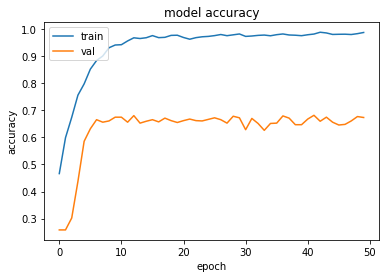

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

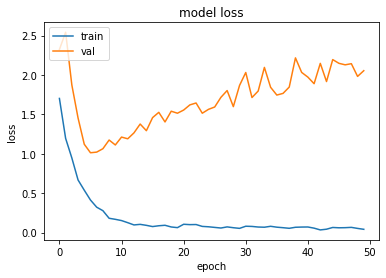

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Transfer Learning

In [15]:
from tensorflow.keras import applications
vgg = applications.VGG16(input_shape=(224,224,3), include_top = False, weights= 'imagenet')

In [16]:
x = vgg.output
x = Flatten()(x)
x = Dense(3078, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(5, activation='softmax')(x)

tf_model = Model(inputs=vgg.input, outputs=out)

for layer in tf_model.layers[:20]:
    layer.trainable=False

tf_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#tf_model.load_weights('TF-CNN.29-0.08-0.98-1.03-0.85.hdf5')
# tf_model.load_weights('cnn_1st_version_h5.hdf5')

filepath = 'TF-CNN.{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5'
lr_red = keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
chkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
tf_model.compile(optimizer = Nadam(0.0001) , loss = 'categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = tf_model.fit(X_train, y_train, batch_size = 1, epochs = 30, initial_epoch = 0, validation_data = (X_val, y_val))

2022-07-11 15:25:43.325006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2079092736 exceeds 10% of free system memory.


Epoch 1/30
3453/3453 [==============================] - ETA: 0s - loss: 1.3278 - accuracy: 0.5656

2022-07-11 16:30:54.096346: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 520224768 exceeds 10% of free system memory.


3453/3453 [==============================] - 3985s 1s/step - loss: 1.3278 - accuracy: 0.5656 - val_loss: 0.6083 - val_accuracy: 0.7766
Epoch 2/30
3453/3453 [==============================] - 3972s 1s/step - loss: 0.7660 - accuracy: 0.7240 - val_loss: 0.7157 - val_accuracy: 0.7234
Epoch 3/30
3453/3453 [==============================] - 3869s 1s/step - loss: 0.6366 - accuracy: 0.7805 - val_loss: 0.5410 - val_accuracy: 0.7951
Epoch 4/30
3453/3453 [==============================] - 4669s 1s/step - loss: 0.4860 - accuracy: 0.8312 - val_loss: 0.6812 - val_accuracy: 0.7593
Epoch 5/30
 983/3453 [=======>......................] - ETA: 1:31:50 - loss: 0.4479 - accuracy: 0.8484